In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/scaler_clustering.csv')

In [ ]:
print(df.head(30))
print(df.shape)

    Unnamed: 0                         company_hash  \
0            0                       atrgxnnt xzaxv   
1            1            qtrxvzwt xzegwgbb rxbxnta   
2            2                        ojzwnvwnxw vx   
3            3                            ngpgutaxv   
4            4                           qxen sqghu   
5            5  yvuuxrj hzbvqqxta bvqptnxzs ucn rna   
6            6                   lubgqsvz wyvot  wg   
7            7                 vwwtznhqt ntwyzgrgsj   
8            8                   utqoxontzn ojontbo   
9            9                                xrbhd   
10          10                      ztfstz ogenfvqt   
11          11                           ngdor ntwy   
12          12           mvqwrvjo wgqugqvnt mvzpxzs   
13          13                            wgszxkvzn   
14          14                               xznhxn   
15          15                               bgsrxd   
16          16                    pnw xzaxv ucn rna   
17        

In [ ]:
df.rename(columns={'Unnamed: 0':'ID'},inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153279 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


In [ ]:
df.isnull().sum()

ID                      0
company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52564
ctc_updated_year        0
dtype: int64

In [ ]:
df['email_hash'].value_counts()

email_hash
bbace3cc586400bbc65765bc6a16b77d8913836cfc98b77c05488f02f5714a4b    10
6842660273f70e9aa239026ba33bfe82275d6ab0d20124021b952b5bc3d07e6c     9
298528ce3160cc761e4dc37a07337ee2e0589df251d73645aae209b010210eee     9
3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94f1c88c5e15a6f31378     9
b4d5afa09bec8689017d8b29701b80d664ca37b83cb883376b2e95191320da66     8
                                                                    ..
bb2fe5e655ada7f7b7ac4a614db0b9c560e796bdfcaa4e5367e69eedfea93876     1
d6cdef97e759dbf1b7522babccbbbd5f164a75d1b4139e02c945958720f1ed79     1
700d1190c17aaa3f2dd9070e47a4c042ecd9205333545dbfaee0f85644d00306     1
c2a1c9e4b9f4e1ed7d889ee4560102c1e2235b2c1a0e59cea95a6fe55c658407     1
0bcfc1d05f2e8dc4147743a1313aa70a119b41b30d4a1f7e738a6a87d3712c31     1
Name: count, Length: 153443, dtype: int64

In [ ]:
df['company_hash'].value_counts()

company_hash
nvnv wgzohrnvzwj otqcxwto         8337
xzegojo                           5381
vbvkgz                            3481
zgn vuurxwvmrt vwwghzn            3411
wgszxkvzn                         3240
                                  ... 
onvqmhwpo                            1
bvsxw ogenfvqt uqxcvnt rxbxnta       1
agsbv ojontbo                        1
vnnhzt xzegwgb                       1
bvptbjnqxu td vbvkgz                 1
Name: count, Length: 37299, dtype: int64

In [ ]:
df['job_position'].value_counts()

job_position
Backend Engineer                 43554
FullStack Engineer               24717
Other                            18071
Frontend Engineer                10417
Engineering Leadership            6870
                                 ...  
PhD. Student                         1
Front-End Developer                  1
ayS                                  1
Principal Product Engineer           1
Android Application developer        1
Name: count, Length: 1016, dtype: int64

In [ ]:
df['ID'].value_counts()

ID
0         1
137694    1
137684    1
137685    1
137686    1
         ..
68713     1
68714     1
68715     1
68716     1
206922    1
Name: count, Length: 205843, dtype: int64

In [ ]:
# df.groupby('email_hash')['ID'].agg('count').sort_values(ascending=False)

df_emailcounts=pd.DataFrame(df['email_hash'].value_counts().reset_index())
df_emailcounts.rename(columns={'count':'email_count'},inplace=True)

df_companycounts=pd.DataFrame(df['company_hash'].value_counts().reset_index())
df_companycounts.rename(columns={'count':'company_count'},inplace=True)

df=pd.merge(df,df_emailcounts)
df=pd.merge(df,df_companycounts)



In [ ]:
df.sort_values(['company_count','email_count','ctc_updated_year'],ascending=[False,False,True]).head(20)

,ID,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,email_count,company_count
49688,4401,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,300000,NaN,2020.0,8,8337
49689,11337,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,300000,Data Scientist,2020.0,8,8337
49690,22427,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,300000,Frontend Engineer,2020.0,8,8337
49691,81153,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,400000,Other,2021.0,8,8337
49692,90953,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,400000,Backend Engineer,2021.0,8,8337
49693,93126,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,400000,Data Scientist,2021.0,8,8337
49694,107679,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,400000,NaN,2021.0,8,8337
49695,132837,nvnv wgzohrnvzwj otqcxwto,d598d6f1fb21b45593c2afc1c2f76ae9f4cb7167156cdf...,2018.0,400000,Frontend Engineer,2021.0,8,8337
54156,131001,nvnv wgzohrnvzwj otqcxwto,571cb2a38ba9337fd5c19fa53467a02bde1944ac4de786...,2018.0,400000,FullStack Engineer,2019.0,6,8337
54157,180041,nvnv wgzohrnvzwj otqcxwto,571cb2a38ba9337fd5c19fa53467a02bde1944ac4de786...,2018.0,400000,Backend Engineer,2019.0,6,8337


# Unsure why there are duplicates of email_hash. Ideally this should be unique to each individual learner. However same value is linked with different job_profiles. For the rest of this analysis, I assume each row is a unique individual.

Top 10 companies learners are associated with

Text(0.5, 0, '')

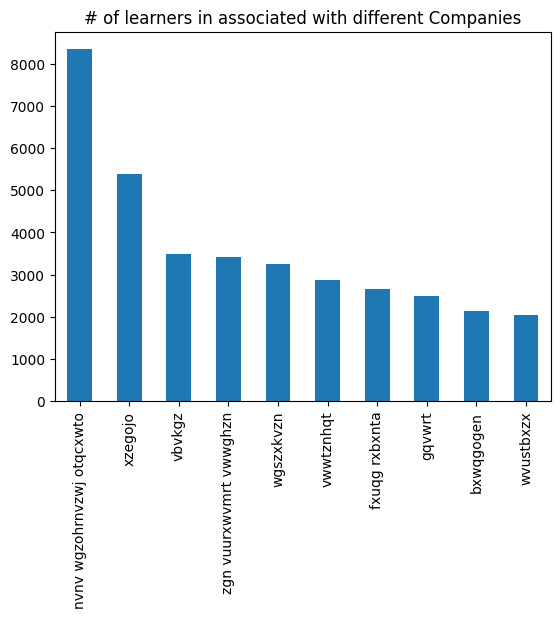

In [ ]:
df['company_hash'].value_counts().head(10).plot(kind='bar')
plt.title('# of learners in associated with different Companies')
plt.xlabel('')

Top 10 roles learners are at

Text(0.5, 0, '')

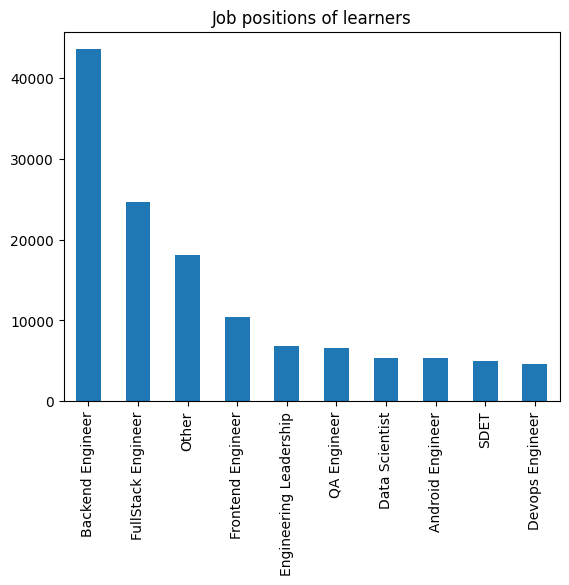

In [ ]:
df['job_position'].value_counts().head(10).plot(kind='bar')
plt.title('Job positions of learners')
plt.xlabel('')

Top repeating email hashes

Text(0.5, 1.0, 'Frequency of occurence of emails')

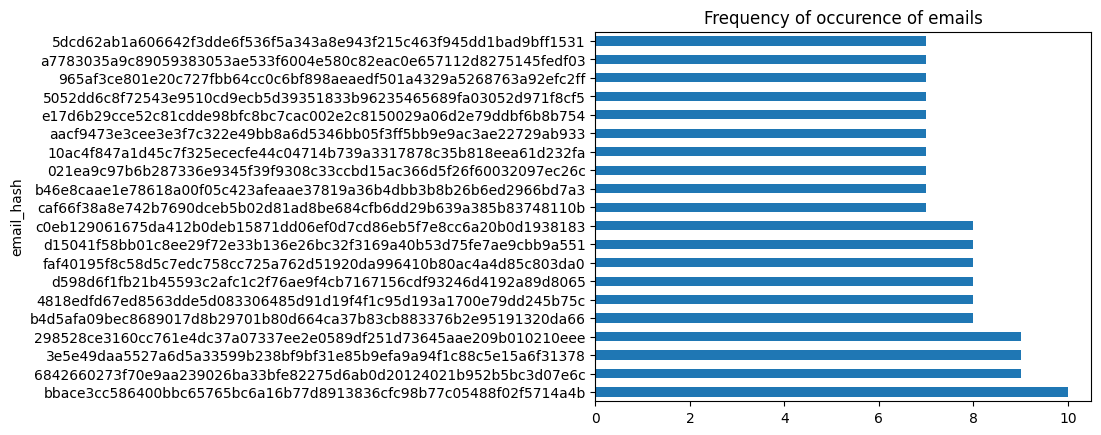

In [ ]:
df['email_hash'].value_counts().head(20).plot(kind='barh')
plt.xlabel('')
plt.title('Frequency of occurence of emails')

In [ ]:
df.isnull().sum()

ID                      0
company_hash            0
email_hash              0
orgyear                86
ctc                     0
job_position        52533
ctc_updated_year        0
email_count             0
company_count           0
dtype: int64

In [ ]:
df[['company_hash','email_hash','orgyear','ctc','job_position','ctc_updated_year']].duplicated().value_counts()

False    205765
True         34
Name: count, dtype: int64

In [ ]:
df.drop_duplicates(subset=['company_hash','email_hash','orgyear','ctc','job_position','ctc_updated_year'],inplace=True)
print(df[['company_hash','email_hash','orgyear','ctc','job_position','ctc_updated_year']].duplicated().value_counts())

False    205765
Name: count, dtype: int64


ToDO

1. what is the typical time for promotion for different roles within and between companies?
2. What is the CTC difference between roles in a company and between companies
3. How did the learners joining scaler change in job role over time?
  **There are corrections needed in orgyear**






# Dropping incorrect data rows

In [ ]:
df.drop(index=df[(df['orgyear']<1000) | (df['orgyear']>df['ctc_updated_year'])].index,inplace=True)
print(df[(df['orgyear']<1000) | (df['orgyear']>df['ctc_updated_year'])])

Empty DataFrame
Columns: [ID, company_hash, email_hash, orgyear, ctc, job_position, ctc_updated_year, email_count, company_count]
Index: []


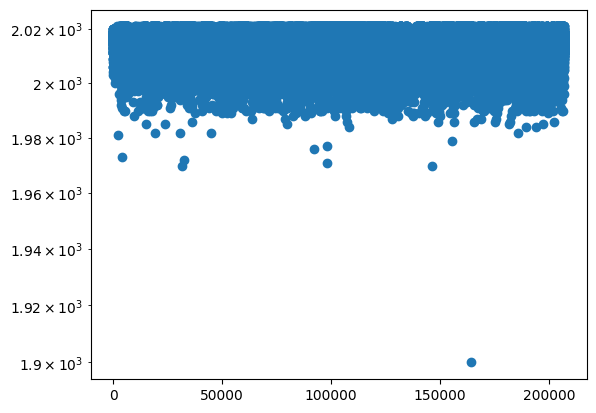

In [ ]:
plt.scatter(df['ID'],df['orgyear'])
plt.yscale('log')

# ToDO: Fill missing values by the most frequent value in the **group**

In [ ]:
# df.groupby('company_hash')['job_position'].value_counts().head(50)

In [ ]:
# df.groupby('company_hash')['job_position'].agg(lambda x: x.value_counts().index[0] if x.nunique()>1 else pd.NA).head(50)

# TO change: Ignoring the unprocessed rows

In [ ]:
df.dropna(axis=0,how='any',inplace=True)

In [ ]:
df.isnull().sum()

ID                  0
company_hash        0
email_hash          0
orgyear             0
ctc                 0
job_position        0
ctc_updated_year    0
email_count         0
company_count       0
dtype: int64

# Feature Engineering

In [ ]:
df['YoE']=df['ctc_updated_year']-df['orgyear']
df['YoE'].describe()

count    148144.000000
mean          4.943474
std           4.101308
min           0.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         119.000000
Name: YoE, dtype: float64

(array([4.5382e+04, 3.8072e+04, 3.5607e+04, 1.1968e+04, 6.4230e+03,
        5.3150e+03, 2.1690e+03, 1.7420e+03, 7.1600e+02, 3.4100e+02,
        2.0600e+02, 8.1000e+01, 8.6000e+01, 1.8000e+01, 5.0000e+00,
        3.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.  ,   2.38,   4.76,   7.14,   9.52,  11.9 ,  14.28,  16.66,
         19.04,  21.42,  23.8 ,  26.18,  28.56,  30.94,  33.32,  35.7 ,
         38.08,  40.46,  42.84,  45.22,  47.6 ,  49.98,  52.36,  54.74,
         57.12,  59.5 ,  61.88,  64.26,  66.64,  69.02,  71.4 ,  73.78,
         76.16,  78.54,  80.92

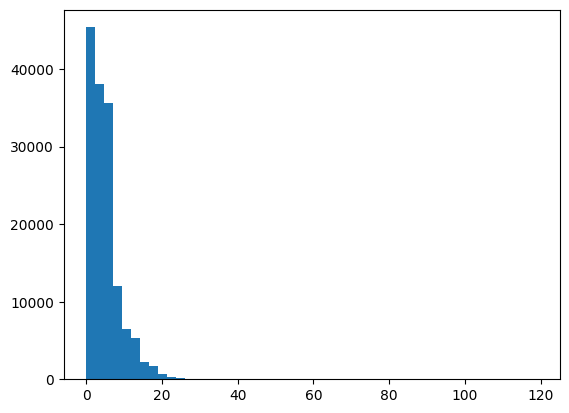

In [ ]:
plt.hist(df['YoE'],bins=50)

In [ ]:
df.sort_values(by='YoE',ascending=False)

,ID,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,email_count,company_count,YoE
199726,164135,ovst xznvwwn ogenfvqt ucn rna,3da3c964efe7a5db0f63e91be25391dcaadf24d44cdc59...,1900.0,3170000,Engineering Leadership,2019.0,1,1,119.0
196721,146388,hzxctqoxnj ge zgqny ntdvo,e66b927f4ee3bd0d7202bbd35486d23d68555fc03dcd54...,1970.0,140000,Engineering Leadership,2020.0,1,2,50.0
187118,97983,wygrvbvzavrvb xzctonbtzn vza exzvzwt wg rna,dc573e5ccc7f6d36b259b939f81655454a6e41a0f79fb5...,1971.0,5500000,Engineering Leadership,2019.0,1,1,48.0
27795,3908,sggsrt,5756870d895deca920251df2377dad261084904a4f9d10...,1973.0,1000,Co-founder,2020.0,1,468,47.0
124466,32701,st ytvrnywvqt,de72685914984cd9e1b0ec13223cd266f3c81d9517f282...,1972.0,2300000,Engineering Leadership,2019.0,1,148,47.0
...,...,...,...,...,...,...,...,...,...,...
26266,119127,zgn vuurxwvmrt vwwghzn,59d6fa07eb1a03b49fb4eb5200bb7875e9c91fc6672a97...,2021.0,300000,Non Coder,2021.0,3,3411,0.0
26265,117745,zgn vuurxwvmrt vwwghzn,59d6fa07eb1a03b49fb4eb5200bb7875e9c91fc6672a97...,2021.0,300000,Support Engineer,2021.0,3,3411,0.0
26249,106375,zgn vuurxwvmrt vwwghzn,08796c76101eb07064141c9dd6747035c4a05b5ba19057...,2021.0,350000,Backend Engineer,2021.0,2,3411,0.0
130307,171741,tcvrhtotqct,9a07fa3752dc5f32c380167a9e97f45dd63a998e8b3e4f...,2020.0,900000,Devops Engineer,2020.0,1,28,0.0


In [ ]:
# df.groupby('email_hash')['ID'].agg('count').sort_values(ascending=False)
df.drop(columns=['email_count','company_count'],inplace=True)

df_emailcounts=pd.DataFrame(df['email_hash'].value_counts().reset_index())
df_emailcounts.rename(columns={'count':'email_count'},inplace=True)

df_companycounts=pd.DataFrame(df['company_hash'].value_counts().reset_index())
df_companycounts.rename(columns={'count':'company_count'},inplace=True)

df_jobcounts=pd.DataFrame(df['job_position'].value_counts().reset_index())
df_jobcounts.rename(columns={'count':'job_count'},inplace=True)


df=pd.merge(df,df_emailcounts)
df=pd.merge(df,df_companycounts)
df=pd.merge(df,df_jobcounts)



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148144 entries, 0 to 205749
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                148144 non-null  int64  
 1   company_hash      148144 non-null  object 
 2   email_hash        148144 non-null  object 
 3   orgyear           148144 non-null  float64
 4   ctc               148144 non-null  int64  
 5   job_position      148144 non-null  object 
 6   ctc_updated_year  148144 non-null  float64
 7   email_count       148144 non-null  int64  
 8   company_count     148144 non-null  int64  
 9   YoE               148144 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 12.4+ MB


In [ ]:
df['company_hash']=df['company_hash'].astype('category')
df['job_position']=df['job_position'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148144 entries, 0 to 205749
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   ID                148144 non-null  int64   
 1   company_hash      148144 non-null  category
 2   email_hash        148144 non-null  object  
 3   orgyear           148144 non-null  float64 
 4   ctc               148144 non-null  int64   
 5   job_position      148144 non-null  category
 6   ctc_updated_year  148144 non-null  float64 
 7   email_count       148144 non-null  int64   
 8   company_count     148144 non-null  int64   
 9   YoE               148144 non-null  float64 
dtypes: category(2), float64(3), int64(4), object(1)
memory usage: 12.3+ MB


In [ ]:
# df_rare=df[df['company_count']<20]
# df_rare.describe()

df['group_company']=df['company_hash']
df.loc[df['company_count']<100,'group_company']='OTHER'
# df['group_company'].fillna('OTHER')

df.head()

,ID,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YoE,group_company,email_count,company_count,job_count,group_job
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0,4.0,OTHER,2,9,17010,Other
1,70864,atrgxnnt xzaxv,696f674fbc0d337b20152f91c43082bafaa243da70932c...,2014.0,1070000,Other,2018.0,4.0,OTHER,1,9,17010,Other
2,336,xzegojo,060332879b510325ae496d07bc96acda88024cd57c56c1...,2017.0,808000,Other,2020.0,3.0,xzegojo,2,3374,17010,Other
3,201584,xzegojo,060332879b510325ae496d07bc96acda88024cd57c56c1...,2017.0,550000,Other,2021.0,4.0,xzegojo,2,3374,17010,Other
4,464,xzegojo,7fb33e269150b9a2e14b51ff905fa461e7000859543d1a...,2016.0,500000,Other,2021.0,5.0,xzegojo,1,3374,17010,Other


In [ ]:
# a=df['company_hash'].value_counts().to_frame()

# plt.hist(a['count'],bins=[0,10,5000])
# plt.show()

df['group_company'].value_counts()

group_company
OTHER                        84307
nvnv wgzohrnvzwj otqcxwto     5183
xzegojo                       3374
vbvkgz                        2453
wgszxkvzn                     2071
                             ...  
adw ntwyzgrgsxto               103
utsvojontbo                    102
st                             102
uvjh                           102
ihxpq                          101
Name: count, Length: 182, dtype: int64

In [ ]:
df['group_job']=df['job_position']
df.loc[df['job_count']<1000,'group_job']='OTHER'

df['group_job'].value_counts()


group_job
Backend Engineer          42324
FullStack Engineer        23849
Other                     17010
Frontend Engineer         10147
Engineering Leadership     6770
QA Engineer                6532
Android Engineer           5248
Data Scientist             5124
SDET                       4907
Devops Engineer            4534
OTHER                      4425
Support Engineer           3557
Data Analyst               2804
iOS Engineer               2705
Engineering Intern         2074
Product Designer           1303
Backend Architect          1276
Fullstack Engineer         1258
Research Engineers         1166
Product Manager            1131
Name: count, dtype: int64

In [ ]:
df['YoE'].value_counts()

YoE
2.0      20868
3.0      20176
4.0      17896
1.0      16168
5.0      14876
6.0      11638
7.0       9093
0.0       8346
8.0       6799
9.0       5169
10.0      3745
11.0      2678
12.0      2108
13.0      1696
14.0      1511
15.0      1227
16.0       942
17.0       696
18.0       542
19.0       504
20.0       442
21.0       274
22.0       202
23.0       139
24.0        83
25.0        65
26.0        58
30.0        53
28.0        46
27.0        35
29.0        33
31.0         8
33.0         6
32.0         4
34.0         3
39.0         2
36.0         2
35.0         2
47.0         2
38.0         1
42.0         1
40.0         1
48.0         1
50.0         1
119.0        1
44.0         1
Name: count, dtype: int64

In [ ]:
# df['group_YoE']=df['YoE']
df['group_YoE']=(np.floor(df['YoE']/3))+1
df['group_YoE'].value_counts()

group_YoE
2.0     52948
1.0     45382
3.0     27530
4.0     11592
5.0      5315
6.0      2865
7.0      1488
8.0       615
9.0       206
10.0      114
11.0       65
12.0       11
13.0        3
14.0        3
15.0        2
16.0        2
17.0        2
40.0        1
Name: count, dtype: int64

In [ ]:
df_desig=df.groupby(['group_company','group_job','group_YoE'])['ctc'].describe()
df_desig.reset_index()

df_desig.drop(columns=['std','25%','75%'],inplace=True)
df_desig.columns=['count_desig','mean_desig','min_desig','median_desig','max_desig']
df=pd.merge(df,df_desig,on=['group_company','group_job','group_YoE'],how='left')

In [ ]:
df_class=df.groupby(['group_company','group_job'])['ctc'].describe()
df_class.reset_index()

df_class.drop(columns=['std','25%','75%'],inplace=True)
df_class.columns=['count_class','mean_class','min_class','median_class','max_class']
df=pd.merge(df,df_class,on=['group_company','group_job'],how='left')

In [ ]:
df_tier=df.groupby('group_company')['ctc'].describe()
df_tier.reset_index()

df_tier.drop(columns=['std','25%','75%'],inplace=True)
df_tier.columns=['count_tier','mean_tier','min_tier','median_tier','max_tier']
df=pd.merge(df,df_tier,on='group_company',how='left')

In [ ]:
df.head()

,ID,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YoE,group_company,email_count,...,count_class,mean_class,min_class,median_class,max_class,count_tier,mean_tier,min_tier,median_tier,max_tier
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0,4.0,OTHER,2,...,8508.0,5.044150e+06,24.0,700000.0,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0
1,70864,atrgxnnt xzaxv,696f674fbc0d337b20152f91c43082bafaa243da70932c...,2014.0,1070000,Other,2018.0,4.0,OTHER,1,...,8508.0,5.044150e+06,24.0,700000.0,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0
2,336,xzegojo,060332879b510325ae496d07bc96acda88024cd57c56c1...,2017.0,808000,Other,2020.0,3.0,xzegojo,2,...,846.0,1.623131e+06,3250.0,430000.0,200000000.0,3374.0,1.235843e+06,3250.0,490000.0,200000000.0
3,201584,xzegojo,060332879b510325ae496d07bc96acda88024cd57c56c1...,2017.0,550000,Other,2021.0,4.0,xzegojo,2,...,846.0,1.623131e+06,3250.0,430000.0,200000000.0,3374.0,1.235843e+06,3250.0,490000.0,200000000.0
4,464,xzegojo,7fb33e269150b9a2e14b51ff905fa461e7000859543d1a...,2016.0,500000,Other,2021.0,5.0,xzegojo,1,...,846.0,1.623131e+06,3250.0,430000.0,200000000.0,3374.0,1.235843e+06,3250.0,490000.0,200000000.0


In [ ]:
# Designation is based on Company, YoE and dept
df['desig']=3
df.loc[df['ctc']==df['median_desig'],'desig']=2
df.loc[df['ctc']>df['median_desig'],'desig']=1

# Class is based on company, dept
df['class']=3
df.loc[df['ctc']==df['median_class'],'class']=2
df.loc[df['ctc']>df['median_class'],'class']=1

# Tier is based on Company
df['tier']=3
df.loc[df['ctc']==df['median_tier'],'tier']=2
df.loc[df['ctc']>df['median_tier'],'tier']=1



In [ ]:
# df_main=df.copy()
# df_main.drop(columns=['ID','company_hash','job_position','YoE','email_count','company_count'],inplace=True)

In [ ]:
df.sort_values('ctc',ascending=False,inplace=True)

In [ ]:
df[df['tier']==1].head(10)

,ID,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YoE,group_company,email_count,...,median_class,max_class,count_tier,mean_tier,min_tier,median_tier,max_tier,desig,class,tier
105721,720,twgbtduqtoo,261f76b9954ebe5e6dc102b0cd5847354cf27112f8a422...,2015.0,200000000,Frontend Engineer,2020.0,5.0,OTHER,1,...,900000.0,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0,1,1,1
118625,72598,nvnv wgzohrnvzwj otqcxwto,b2d195a3bf7aab1059a4401fa271de292e308248db6cfd...,2017.0,200000000,Support Engineer,2020.0,3.0,nvnv wgzohrnvzwj otqcxwto,1,...,420000.0,200000000.0,5183.0,1.695569e+06,600.0,450000.0,200000000.0,1,1,1
8923,45813,otre tburgjta,5f39783f33de6430635e8e1770cc93e9d73e40cd7ed6dd...,2017.0,200000000,Other,2020.0,3.0,otre tburgjta,1,...,500000.0,200000000.0,469.0,7.287862e+06,7000.0,600000.0,200000000.0,1,1,1
8891,2959,otre tburgjta,2dfd6e8346ec1a69281cdb0242e3812982639f73bb7893...,2019.0,200000000,Other,2020.0,1.0,otre tburgjta,1,...,500000.0,200000000.0,469.0,7.287862e+06,7000.0,600000.0,200000000.0,1,1,1
8890,1052,otre tburgjta,4f83774dfe4b97bfd0836463f3a573aa82725aa8e0f4a4...,2020.0,200000000,Other,2020.0,0.0,otre tburgjta,1,...,500000.0,200000000.0,469.0,7.287862e+06,7000.0,600000.0,200000000.0,1,1,1
141715,29753,ctwngq oyvato,f792547152a99e365d72171ef22b5aa6232dc1baa17fed...,2016.0,200000000,Backend Architect,2020.0,4.0,OTHER,1,...,2600000.0,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0,1,1,1
8619,29455,gnytqo,4a9560a82ae4b29d77d2ed6b0cb54ffbd28b7aa3fd5110...,2019.0,200000000,Other,2020.0,1.0,gnytqo,1,...,550000.0,200000000.0,115.0,1.080630e+07,1000.0,500000.0,200000000.0,1,1,1
8614,19608,gnytqo,e7b2b159325f77e7abd5aa938371d7f9425530b36e703f...,2013.0,200000000,Other,2020.0,7.0,gnytqo,1,...,550000.0,200000000.0,115.0,1.080630e+07,1000.0,500000.0,200000000.0,1,1,1
19972,79049,vbagwo,27ee35ce0f4e1ce38f0c342b17f987727261dfef452767...,2016.0,200000000,Backend Engineer,2020.0,4.0,vbagwo,1,...,750000.0,200000000.0,605.0,1.635038e+06,4000.0,750000.0,200000000.0,1,1,1
82932,16465,zxxn ntwyzgrgsxto rxbxnta,58e652d3e06d4228be0a8ac9ef8228928628299d93795f...,2014.0,200000000,FullStack Engineer,2020.0,6.0,OTHER,1,...,868999.5,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0,1,1,1


In [ ]:
# df_main['group_job'].value_counts()

group_job
Backend Engineer          42324
FullStack Engineer        23849
Other                     17010
Frontend Engineer         10147
Engineering Leadership     6770
QA Engineer                6532
Android Engineer           5248
Data Scientist             5124
SDET                       4907
Devops Engineer            4534
OTHER                      4425
Support Engineer           3557
Data Analyst               2804
iOS Engineer               2705
Engineering Intern         2074
Product Designer           1303
Backend Architect          1276
Fullstack Engineer         1258
Research Engineers         1166
Product Manager            1131
Name: count, dtype: int64

In [ ]:
df[(df['group_job']=='Data Scientist') & (df['class']==1)].head(10)

,ID,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YoE,group_company,email_count,...,median_class,max_class,count_tier,mean_tier,min_tier,median_tier,max_tier,desig,class,tier
62695,31329,ihvaqvnxw xzoxsyno ucn rna,bd222ea783ee372da4e0ad60fdccec0b8f37999a032025...,2015.0,200000000,Data Scientist,2019.0,4.0,OTHER,1,...,1160000.0,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0,1,1,1
61855,836,mqxonrtwgzt v bvyxzaqv sqghu wgbuvzj,cda8d723438e81185d2ee8c348870a4612eea974cdb2db...,2017.0,200000000,Data Scientist,2020.0,3.0,OTHER,1,...,1160000.0,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0,1,1,1
62029,2688,ptnovvr qtnvxr rru,72ed7ced98573f71c8f95bc8b75aac4f0677e8872c6bec...,2019.0,199800000,Data Scientist,2020.0,1.0,OTHER,1,...,1160000.0,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0,1,1,1
62066,45264,pgnvp,ace1152ca60b6f2c62bb7c4a00bca0afd5a9bb2c297267...,1992.0,150000000,Data Scientist,2020.0,28.0,OTHER,1,...,1160000.0,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0,1,1,1
62719,36834,wrghaotp,a1223067ab5c4ff7fcf39ed4c053057f06090a57fc05ba...,2017.0,127600000,Data Scientist,2020.0,3.0,OTHER,2,...,1160000.0,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0,1,1,1
61962,1736,myvoyjvb owyggr,ee8dd42d6ea8365909147d861c7978d19f727a8075ba96...,2020.0,102500000,Data Scientist,2020.0,0.0,OTHER,1,...,1160000.0,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0,1,1,1
62440,13526,utqtzsg,e7722fb701c61e5cad82c39ee8bf3debe160d429b72c64...,2015.0,100000000,Data Scientist,2020.0,5.0,OTHER,1,...,1160000.0,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0,1,1,1
62597,123103,xzzgcv ogrhnxgzo,6b6dd66bae787dd4dd417e1777f8ea5a057257e9019995...,2016.0,100000000,Data Scientist,2020.0,4.0,OTHER,1,...,1160000.0,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0,1,1,1
62765,32250,otre tburgjta uqgetooxgzvr,5dd32aca5f483b8fa4d539778bb3f0a24073a93a80dd5a...,2010.0,100000000,Data Scientist,2020.0,10.0,OTHER,1,...,1160000.0,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0,1,1,1
62072,23574,xzegsvxz xzaxv uqxcvnt rxbxnta,9ddd3b9e97841f9713b1e17a264656efdf9b6fd8ba169b...,2015.0,100000000,Data Scientist,2020.0,5.0,OTHER,1,...,1160000.0,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0,1,1,1


In [ ]:
df[(df['group_job']=='Data Scientist') & (df['class']==3)].head(10)

,ID,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YoE,group_company,email_count,...,median_class,max_class,count_tier,mean_tier,min_tier,median_tier,max_tier,desig,class,tier
60387,183876,sgrabvz ovwyo,ba4fc863ae48a6f0f68a60706a4c91cd249ffa3ff87b61...,2018.0,3300000,Data Scientist,2019.0,1.0,sgrabvz ovwyo,1,...,3650000.0,5700000.0,628.0,3.078264e+06,26000.0,2793000.0,100000000.0,1,3,1
60379,134771,sgrabvz ovwyo,15777960f3e1deeda22307fff20af0a88fc6d82d6ba571...,2017.0,3200000,Data Scientist,2019.0,2.0,sgrabvz ovwyo,5,...,3650000.0,5700000.0,628.0,3.078264e+06,26000.0,2793000.0,100000000.0,3,3,1
60385,130088,sgrabvz ovwyo,e3d1596010c7642abaaf09659077210aec53e057b74292...,2017.0,3200000,Data Scientist,2019.0,2.0,sgrabvz ovwyo,1,...,3650000.0,5700000.0,628.0,3.078264e+06,26000.0,2793000.0,100000000.0,3,3,1
59715,104910,erxupvqn,71dd396ef6049136a7321d549b117d91f4b3c2d1bc82ab...,2015.0,3200000,Data Scientist,2021.0,6.0,erxupvqn,2,...,3450000.0,8500000.0,728.0,3.316140e+06,10000.0,2650000.0,200000000.0,1,3,1
60171,90794,ofxssj,e0415c8e1a9078337e1447c94f0d8a007fecacf26ac841...,2013.0,3150000,Data Scientist,2015.0,2.0,ofxssj,1,...,3300000.0,5500000.0,197.0,4.359802e+06,168000.0,2700000.0,200000000.0,1,3,1
60550,70549,fvrbvqn rvmo,fb0ab058c396d168fec55368eeae3f3c8024ca9f324dfe...,2013.0,3100000,Data Scientist,2019.0,6.0,fvrbvqn rvmo,1,...,3675000.0,12000000.0,585.0,2.872310e+06,13000.0,2565000.0,17600000.0,3,3,1
60552,101371,fvrbvqn rvmo,867985df71d6a74ea4ce223f2cdc83dbd80bd52cc5f70a...,2017.0,3100000,Data Scientist,2021.0,4.0,fvrbvqn rvmo,1,...,3675000.0,12000000.0,585.0,2.872310e+06,13000.0,2565000.0,17600000.0,1,3,1
60384,143649,sgrabvz ovwyo,3d227c58415b7aacd909debc5d55cd2dbe168fa0ee57c6...,2018.0,3000000,Data Scientist,2021.0,3.0,sgrabvz ovwyo,1,...,3650000.0,5700000.0,628.0,3.078264e+06,26000.0,2793000.0,100000000.0,3,3,1
60566,183945,fvrbvqn rvmo,aa415aa0faac14248b4d8e5ffac91a5c91a7f48faf780d...,2017.0,3000000,Data Scientist,2020.0,3.0,fvrbvqn rvmo,1,...,3675000.0,12000000.0,585.0,2.872310e+06,13000.0,2565000.0,17600000.0,3,3,1
59717,121185,erxupvqn,d6e0db35b751edf14d8fbe621481e28aab9df264796c24...,2014.0,3000000,Data Scientist,2021.0,7.0,erxupvqn,1,...,3450000.0,8500000.0,728.0,3.316140e+06,10000.0,2650000.0,200000000.0,3,3,1


In [ ]:
df[df['tier']==3].head(10)

,ID,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YoE,group_company,email_count,...,median_class,max_class,count_tier,mean_tier,min_tier,median_tier,max_tier,desig,class,tier
101114,101699,hmtq,be0787671d8b1a9789f33303e0bb7cd1cd8624221575a1...,2015.0,3500000,Frontend Engineer,2019.0,4.0,hmtq,1,...,3350000.0,7200000.0,131.0,5.371034e+06,3900.0,3600000.0,100000000.0,2,1,3
64598,158647,hmtq,2fdaf89454366ff0a27fa2519502c57192149ad858a094...,2011.0,3500000,Android Engineer,2019.0,8.0,hmtq,1,...,4600000.0,100000000.0,131.0,5.371034e+06,3900.0,3600000.0,100000000.0,3,3,3
79401,20915,hmtq,7b6995298e4316fdec117300a3b5c4ee41afa066e6f684...,2017.0,3450000,FullStack Engineer,2020.0,3.0,hmtq,1,...,4300000.0,56000000.0,131.0,5.371034e+06,3900.0,3600000.0,100000000.0,1,3,3
22105,190687,hmtq,93052766a1dbc33b67c2a22882ae88fe14efcee728a654...,2018.0,3400000,Backend Engineer,2019.0,1.0,hmtq,1,...,4000000.0,15300000.0,131.0,5.371034e+06,3900.0,3600000.0,100000000.0,1,3,3
22103,183695,hmtq,2017204a805622127f9694b1775c4d928a06f93cc435d2...,2017.0,3400000,Backend Engineer,2020.0,3.0,hmtq,1,...,4000000.0,15300000.0,131.0,5.371034e+06,3900.0,3600000.0,100000000.0,3,3,3
22060,47850,hmtq,40b2af95ca5cd4f45d7c6a8570a34930ffd227ae38ff09...,2016.0,3300000,Backend Engineer,2021.0,5.0,hmtq,1,...,4000000.0,15300000.0,131.0,5.371034e+06,3900.0,3600000.0,100000000.0,3,3,3
79407,203473,hmtq,ddc9307b4aa9b6c28def94bd4e8dca32a1d9aa0c9fd708...,2015.0,3250000,FullStack Engineer,2019.0,4.0,hmtq,2,...,4300000.0,56000000.0,131.0,5.371034e+06,3900.0,3600000.0,100000000.0,2,3,3
101117,167481,hmtq,ab1826b26b3d1ce2da2b69b319baea892dc0ae68ff898c...,2011.0,3200000,Frontend Engineer,2015.0,4.0,hmtq,1,...,3350000.0,7200000.0,131.0,5.371034e+06,3900.0,3600000.0,100000000.0,3,3,3
22083,133364,hmtq,3a0943675fbbab95a8ccd256def6d057e53adbe2441887...,2018.0,3200000,Backend Engineer,2020.0,2.0,hmtq,1,...,4000000.0,15300000.0,131.0,5.371034e+06,3900.0,3600000.0,100000000.0,2,3,3
22064,73945,hmtq,ef3014217d2dbec9fb3f71eb8d61b23c8db3adfba702d9...,2015.0,3200000,Backend Engineer,2019.0,4.0,hmtq,2,...,4000000.0,15300000.0,131.0,5.371034e+06,3900.0,3600000.0,100000000.0,3,3,3


In [ ]:
df.head(10)

,ID,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year,YoE,group_company,email_count,...,median_class,max_class,count_tier,mean_tier,min_tier,median_tier,max_tier,desig,class,tier
105721,720,twgbtduqtoo,261f76b9954ebe5e6dc102b0cd5847354cf27112f8a422...,2015.0,200000000,Frontend Engineer,2020.0,5.0,OTHER,1,...,900000.0,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0,1,1,1
118625,72598,nvnv wgzohrnvzwj otqcxwto,b2d195a3bf7aab1059a4401fa271de292e308248db6cfd...,2017.0,200000000,Support Engineer,2020.0,3.0,nvnv wgzohrnvzwj otqcxwto,1,...,420000.0,200000000.0,5183.0,1.695569e+06,600.0,450000.0,200000000.0,1,1,1
8923,45813,otre tburgjta,5f39783f33de6430635e8e1770cc93e9d73e40cd7ed6dd...,2017.0,200000000,Other,2020.0,3.0,otre tburgjta,1,...,500000.0,200000000.0,469.0,7.287862e+06,7000.0,600000.0,200000000.0,1,1,1
8891,2959,otre tburgjta,2dfd6e8346ec1a69281cdb0242e3812982639f73bb7893...,2019.0,200000000,Other,2020.0,1.0,otre tburgjta,1,...,500000.0,200000000.0,469.0,7.287862e+06,7000.0,600000.0,200000000.0,1,1,1
8890,1052,otre tburgjta,4f83774dfe4b97bfd0836463f3a573aa82725aa8e0f4a4...,2020.0,200000000,Other,2020.0,0.0,otre tburgjta,1,...,500000.0,200000000.0,469.0,7.287862e+06,7000.0,600000.0,200000000.0,1,1,1
141715,29753,ctwngq oyvato,f792547152a99e365d72171ef22b5aa6232dc1baa17fed...,2016.0,200000000,Backend Architect,2020.0,4.0,OTHER,1,...,2600000.0,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0,1,1,1
8619,29455,gnytqo,4a9560a82ae4b29d77d2ed6b0cb54ffbd28b7aa3fd5110...,2019.0,200000000,Other,2020.0,1.0,gnytqo,1,...,550000.0,200000000.0,115.0,1.080630e+07,1000.0,500000.0,200000000.0,1,1,1
8614,19608,gnytqo,e7b2b159325f77e7abd5aa938371d7f9425530b36e703f...,2013.0,200000000,Other,2020.0,7.0,gnytqo,1,...,550000.0,200000000.0,115.0,1.080630e+07,1000.0,500000.0,200000000.0,1,1,1
19972,79049,vbagwo,27ee35ce0f4e1ce38f0c342b17f987727261dfef452767...,2016.0,200000000,Backend Engineer,2020.0,4.0,vbagwo,1,...,750000.0,200000000.0,605.0,1.635038e+06,4000.0,750000.0,200000000.0,1,1,1
82932,16465,zxxn ntwyzgrgsxto rxbxnta,58e652d3e06d4228be0a8ac9ef8228928628299d93795f...,2014.0,200000000,FullStack Engineer,2020.0,6.0,OTHER,1,...,868999.5,200000000.0,84307.0,2.343548e+06,2.0,950000.0,200000000.0,1,1,1


In [ ]:
df.groupby('company_hash')['job_position'].nth([0,1]).value_counts()

job_position
Backend Engineer                           8701
FullStack Engineer                         6338
Other                                      4705
Frontend Engineer                          3426
Engineering Leadership                     3026
                                           ... 
Senior Software Development Engineer II       1
Team Lead Mobile                              1
Quantitative Analyst                          1
Digital marketing manager                     1
Matlab programmer                             1
Name: count, Length: 311, dtype: int64

# Data processing for Unsupervised learning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148144 entries, 105721 to 33230
Data columns (total 32 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                148144 non-null  int64  
 1   company_hash      148144 non-null  object 
 2   email_hash        148144 non-null  object 
 3   orgyear           148144 non-null  float64
 4   ctc               148144 non-null  int64  
 5   job_position      148144 non-null  object 
 6   ctc_updated_year  148144 non-null  float64
 7   YoE               148144 non-null  float64
 8   group_company     148144 non-null  object 
 9   email_count       148144 non-null  int64  
 10  company_count     148144 non-null  int64  
 11  job_count         148144 non-null  int64  
 12  group_job         148144 non-null  object 
 13  group_YoE         148144 non-null  float64
 14  count_desig       148144 non-null  float64
 15  mean_desig        148144 non-null  float64
 16  min_desig         148

In [ ]:
X=df[['group_company','orgyear','ctc','group_job','ctc_updated_year','YoE','desig','class','tier']]
X.head()

,group_company,orgyear,ctc,group_job,ctc_updated_year,YoE,desig,class,tier
105721,OTHER,2015.0,200000000,Frontend Engineer,2020.0,5.0,1,1,1
118625,nvnv wgzohrnvzwj otqcxwto,2017.0,200000000,Support Engineer,2020.0,3.0,1,1,1
8923,otre tburgjta,2017.0,200000000,Other,2020.0,3.0,1,1,1
8891,otre tburgjta,2019.0,200000000,Other,2020.0,1.0,1,1,1
8890,otre tburgjta,2020.0,200000000,Other,2020.0,0.0,1,1,1


In [ ]:
# pd.get_dummies(X[['group_company','group_job']],prefix=['company','job'])

X=X.join(pd.get_dummies(X[['group_company','group_job']],prefix=['company','job']))
X.drop(columns=['group_company','group_job'],inplace=True)

X.head()

,orgyear,ctc,ctc_updated_year,YoE,desig,class,tier,company_OTHER,company_adw ntwyzgrgsj,company_adw ntwyzgrgsxto,...,job_Fullstack Engineer,job_OTHER,job_Other,job_Product Designer,job_Product Manager,job_QA Engineer,job_Research Engineers,job_SDET,job_Support Engineer,job_iOS Engineer
105721,2015.0,200000000,2020.0,5.0,1,1,1,True,False,False,...,False,False,False,False,False,False,False,False,False,False
118625,2017.0,200000000,2020.0,3.0,1,1,1,False,False,False,...,False,False,False,False,False,False,False,False,True,False
8923,2017.0,200000000,2020.0,3.0,1,1,1,False,False,False,...,False,False,True,False,False,False,False,False,False,False
8891,2019.0,200000000,2020.0,1.0,1,1,1,False,False,False,...,False,False,True,False,False,False,False,False,False,False
8890,2020.0,200000000,2020.0,0.0,1,1,1,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [ ]:
X.describe()

,orgyear,ctc,ctc_updated_year,YoE,desig,class,tier
count,148144.000000,1.481440e+05,148144.000000,148144.000000,148144.000000,148144.000000,148144.000000
mean,2014.617089,2.317751e+06,2019.560563,4.943474,1.999372,2.001289,1.996267
std,4.261900,1.157996e+07,1.253729,4.101308,0.961835,0.983102,0.991975
min,1900.000000,2.000000e+00,2015.000000,0.000000,1.000000,1.000000,1.000000
25%,2013.000000,5.780000e+05,2019.000000,2.000000,1.000000,1.000000,1.000000
50%,2015.000000,1.000000e+06,2020.000000,4.000000,2.000000,2.000000,2.000000
75%,2018.000000,1.725750e+06,2021.000000,7.000000,3.000000,3.000000,3.000000
max,2021.000000,2.000000e+08,2021.000000,119.000000,3.000000,3.000000,3.000000


In [ ]:
from sklearn.preprocessing import MinMaxScaler

mms=MinMaxScaler()
X_scaled=mms.fit_transform(X)

X_scaled

array([[9.50413223e-01, 1.00000000e+00, 8.33333333e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.66942149e-01, 1.00000000e+00, 8.33333333e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [9.66942149e-01, 1.00000000e+00, 8.33333333e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.58677686e-01, 1.15000001e-07, 5.00000000e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.91735537e-01, 1.10000001e-07, 8.33333333e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.42148760e-01, 0.00000000e+00, 6.66666667e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
X_scaled.shape

(148144, 209)

In [ ]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2).fit_transform(X_scaled)

In [ ]:
pca.shape

(148144, 2)

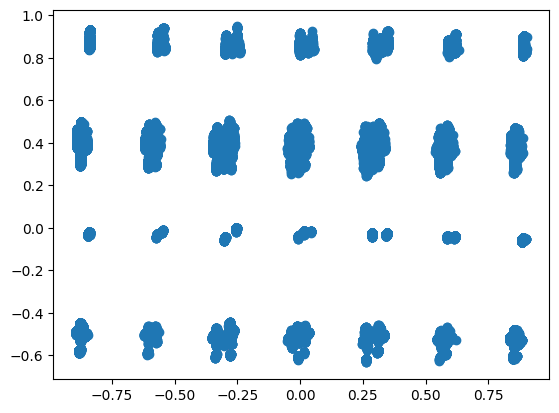

In [ ]:
plt.scatter(pca[:,0],pca[:,1])

In [ ]:
from sklearn.manifold import TSNE

tsne=TSNE(n_components=2).fit_transform(X_scaled)
tsne.shape

(148144, 2)

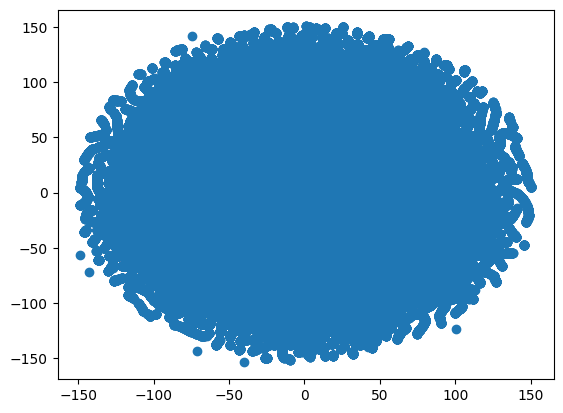

In [ ]:
plt.scatter(tsne[:,0],tsne[:,1])